In technical terms, here’s how a VAE works:
1. An encoder module turns the input samples `input_img` into two parameters in a latent space of representations, `z_mean` and `z_log_variance`.
2. You randomly sample a point `z` from the latent normal distribution that’s assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values.
3. A decoder module maps this point in the latent space back to the original input image.

Because `epsilon` is random, the process ensures that every point that’s close to the latent location where you encoded `input_img (z-mean)` can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful.

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


The following listing shows the encoder network we’ll use, mapping images to the parameters of a probability distribution over the latent space. It’s a simple convnet that maps the input image `x` to two vectors, `z_mean` and `z_log_var`

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
# Dimensionality of latent space: a 2D space
latent_dim = 2

In [3]:
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# The image ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Next is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a Lambda layer. In Keras, everything needs to be a layer, so code that isn’t part of a built- in layer should be wrapped in a Lambda (or in a custom layer).

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Now, let do the `decoder` implementation

In [6]:
decoder_input = layers.Input(K.int_shape(z)[1:])

# Unflattens the input
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
# Reshapes z into a feature map of the same shape as the feature map 
# just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

# Uses a Conv2DTranspose layer and Conv2D layer to decode z into a feature map 
# the same size as the original image input
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# Instantiates the decoder model, which turns “decoder_input” into the decoded image
decoder = Model(decoder_input, x)
# Applies it to z to recover the decoded z
z_decoded = decoder(z)

VAEs minimise a dual-loss: a **reconstruction loss** that forces the decoded samples to match the initial inputs, and a **regularization loss** that helps learn well-formed latent spaces and reduce overfitting to the training data. To define this function we a custom layer that internally uses the built-in `add_loss` layer method to create an arbitrary loss.

In [7]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # Custom layers are implemented by writing a call method
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # Note that this output is not used but the layer must return something
        return x

# Call customer layer on the input and the decoded output to obtain the final model output
y = CustomVariationalLayer()([input_img, z_decoded])

Now we can instantiate and train the model. Because the loss is taken care of in the custom layer, we don't specify an external loss at compile time (`loss=None`), which in turn means we won’t pass target data during training (we only pass `x_train` to the model in `fit`).

In [8]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

/usr/lib/python3.4/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


In [12]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [14]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 57s 947us/step - loss: 1160163570.7019 - val_loss: 0.1999
Epoch 2/10
60000/60000 [==============================] - 53s 879us/step - loss: 0.1958 - val_loss: 0.1916
Epoch 3/10
60000/60000 [==============================] - 53s 880us/step - loss: 0.1901 - val_loss: 0.1876
Epoch 4/10
60000/60000 [==============================] - 53s 880us/step - loss: 0.1871 - val_loss: 0.1855
Epoch 5/10
60000/60000 [==============================] - 53s 880us/step - loss: 0.1854 - val_loss: 0.1839
Epoch 6/10
60000/60000 [==============================] - 53s 880us/step - loss: 0.1839 - val_loss: 0.1830
Epoch 7/10
60000/60000 [==============================] - 53s 880us/step - loss: 0.1831 - val_loss: 0.1823
Epoch 8/10
60000/60000 [==============================] - 53s 880us/step - loss: 0.1822 - val_loss: 0.1818
Epoch 9/10
60000/60000 [==============================] - 53s 880us/step - loss: 0.18

We can now use the decoder network to turn arbitrary latent space vectors into images. We can see that the latent space is continuous and that specific directions have a meaning (e.g. one-ness, two-ness, etc.)

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# We display a grid of 15 × 15 digits (255 digits total).
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        # Decodes the batch into digit images
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        # Reshapes the first digit in the batch from 28 × 28 × 1 to 28 × 28
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

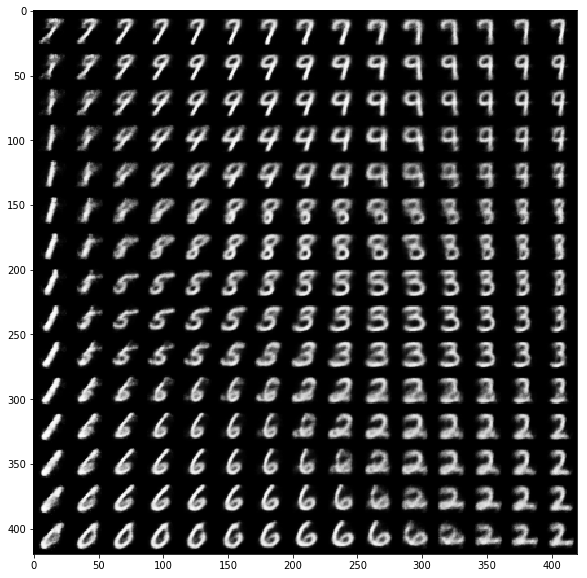

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Image generation with deep learning is done by learning latent spaces that capture statistical information about a dataset of images. By sampling and decoding points from the latent space, you can generate never-before-seen images.
VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of image editing in latent space: face swapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing latent-space-based animations, such as animating a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way.